## This script is currently set to emulation mode for demonstrational purposes. If you wish to run the experiments on the instruments, please change the following parameter to false!

In [31]:
#Emulation mode?
emulate = True

# Initial Setup

## 0.1 Imports

In [32]:
#Initial Imports
%config IPCompleter.greedy=True

from laboneq.contrib.example_helpers.plotting.plot_helpers import *

# LabOne Q:
from laboneq.simple import *

# Helpers:
from laboneq.analysis.fitting import oscillatory
from laboneq.contrib.example_helpers.plotting.plot_helpers import (
    plot_results,
    plot_simulation,
)


from laboneq.contrib.example_helpers.generate_example_datastore import (
    generate_example_datastore,
    get_first_named_entry,
)

# plotting and fitting functionality
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
)
from pathlib import Path
import time

from tuneup_helper import *

import numpy as np
import matplotlib.pyplot as plt

## 0.2 Device Setup

In [33]:
#DESCRITPTOR 
#Define initial PHYSICAL device setup, Logical Signal Lines of the Instrument are defined here and later in a Signal Map mapped to the Experimental Signal lines 

#Fill in missing HDAWG


"""Descriptor for a QCCS consisting of SHFSG, SHFQA, and PQSC
"""

descriptor_shfsg_shfqa_pqsc = """
instruments:
  SHFQA:
  - address: DEV12249
    uid: device_shfqa
  SHFSG:
  - address: DEV12265
    uid: device_shfsg
  PQSC:
  - address: DEV10094
    uid: device_pqsc

connections:
  device_shfqa:
    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q2/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q2/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q3/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q3/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q4/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q4/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q5/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q5/acquire_line
      ports: [QACHANNELS/0/INPUT]

  device_shfsg:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: q0/drive_line_ef
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: q1/drive_line
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: q1/drive_line_ef
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: q2/drive_line
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: q2/drive_line_ef
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: q3/drive_line
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: q3/drive_line_ef
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: q4/drive_line
      ports: SGCHANNELS/4/OUTPUT
    - iq_signal: q4/drive_line_ef
      ports: SGCHANNELS/4/OUTPUT
    - iq_signal: q5/drive_line
      ports: SGCHANNELS/5/OUTPUT
    - iq_signal: q5/drive_line_ef
      ports: SGCHANNELS/5/OUTPUT

  device_pqsc:
    # - internal_clock_signal
    - to: device_shfqa
      port: ZSYNCS/0
    - to: device_shfsg
      port: ZSYNCS/1
"""

# define the DeviceSetup from descriptor - additionally include information on the dataserver used to connect to the instruments 
#with the device set
device_setup = DeviceSetup.from_descriptor(
    #or with example import and yaml also possible: yaml_text=descriptor_shfsg_shfqa_pqsc
    descriptor_shfsg_shfqa_pqsc,
    server_host="192.168.1.10", #IP-Address of the LabOne (NOT Q) dataserver used to communicate with the instrument
    server_port="8004",
    setup_name="psi",
) 

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}

## 0.3 Qubit Parameters

In [34]:
# a function to define a collection of single qubit control and readout parameters as a python dictionary


def single_qubit_parameters():
    return {
        'ro_freq' :  10e6,           # readout frequency of qubit 0 in [Hz] - relative to local oscillator for readout drive upconversion
        'ro_amp' : 0.5,              # readout amplitude
        'ro_amp_spec': 0.05,         # readout amplitude for spectroscopy
        'ro_len' : 1.0e-6,           # readout pulse length in [s]
        'ro_len_spec' : 1.0e-6,      # readout pulse length for resonator spectroscopy in [s]
        'ro_delay': 100e-9,          # readout delay after last drive signal in [s]
        'ro_int_delay' : 180e-9,     # readout line offset calibration - delay between readout pulse and start of signal acquisition in [s]

        "freq": 20e6,                # qubit 0 drive frequency in [Hz] - relative to local oscillator for qubit drive upconversion
        'qb_amp_spec': 0.01,         # drive amplitude of qubit spectroscopy
        'qb_len_spec': 15e-6,        # drive pulse length for qubit spectroscopy in [s]
        'qb_len' : 4e-7,             # qubit drive pulse length in [s]
        'pi_amp' : 0.5,              # qubit drive amplitude for pi pulse
        'pi_half_amp' : 0.25,        # qubit drive amplitude for pi/2 pulse
        'qb_t1' : 100e-6,            # qubit T1 time
        'qb_t2' : 100e-6,            # qubit T2 time
        'relax' : 200e-6             # delay time after each measurement for qubit reset in [s]
    }


# for sake of simplicity, give all qubits the same initial parameters
qubit_parameters = {
    k: single_qubit_parameters() for k in device_setup.logical_signal_groups.keys()
}
qubit_parameters['q0'] = single_qubit_parameters()

# up / downconversion settings - to convert between IF and RF frequencies
def single_lo_settings():
    return {
        # SHFQA LO Frequency
        "shfqa_lo": 8.0e9,
        # SHFSG LO Frequencies, one center frequency per two channels on SHFQC
        "shfsg_lo": 5.0e9,
    }


lo_settings = {
    k: single_lo_settings() for k in device_setup.logical_signal_groups.keys()
}

## 0.4 Calibration

In [35]:
# function that defines the device settings for qubit and readout parameters


def define_calibration(device_setup, parameters, lo_settings):
    # Define LOs
    def single_oscillator(id, qubit, lo_type):
        oscillator = Oscillator()
        oscillator.uid = f"{id}" + f"{qubit}" + "_osc"
        oscillator.frequency = lo_settings[qubit][lo_type]
        return oscillator

    readout_lo_dict = {
        k: single_oscillator("readout_lo_", k, "shfqa_lo")
        for k in device_setup.logical_signal_groups.keys()
    }

    drive_lo_dict = {
        k: single_oscillator("drive_lo_", k, "shfsg_lo")
        for k in device_setup.logical_signal_groups.keys()
    }

    # the calibration object will later be applied to the device setup
    calibration = Calibration()

    # qubits q0-q3 are multiplexed on one acquisition line
    calibration[
        device_setup.logical_signal_groups["q0"].logical_signals["acquire_line"]
    ] = SignalCalibration(
        oscillator=Oscillator(
            frequency=parameters["q0"]["ro_freq"],
            modulation_type=ModulationType.SOFTWARE,
        ),
        # add an offset between the readout pulse and the start of the data acquisition - to compensate for round-trip time of readout pulse
        port_delay=parameters["q0"]["ro_delay"] + parameters["q0"]["ro_int_delay"],
        local_oscillator=readout_lo_dict["q0"],
        range=5,
    )

    for logical_signal_group in device_setup.logical_signal_groups.keys():
        # measure line
        calibration[
            device_setup.logical_signal_groups[logical_signal_group].logical_signals[
                "measure_line"
            ]
        ] = SignalCalibration(
            oscillator=Oscillator(
                frequency=parameters[logical_signal_group]["ro_freq"],
                modulation_type=ModulationType.SOFTWARE,
            ),
            port_delay=parameters["q0"]["ro_delay"],
            local_oscillator=readout_lo_dict["q0"],
            range=5,
        )

        calibration[
            device_setup.logical_signal_groups[logical_signal_group].logical_signals[
                "drive_line"
            ]
        ] = SignalCalibration(
            # each logical signal can have an oscillator associated with it
            oscillator=Oscillator(
                frequency=parameters[logical_signal_group]["freq"],
                modulation_type=ModulationType.HARDWARE,
            ),
            # DANGER! Verify which qubits share the same LOs!
            local_oscillator=drive_lo_dict[logical_signal_group],
            range=5,
        )
    return calibration

## 0.5 Apply Calibration and connect

In [36]:
# define Calibration object based on qubit control and readout parameters
calibration = define_calibration(device_setup, qubit_parameters, lo_settings)
# apply calibration to device setup
device_setup.set_calibration(calibration)



# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2023.11.13 14:21:13.868] INFO    Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is u:\LabOneQ Software Local Samuel\laboneq\LabPC_Software\laboneq_output\log
[2023.11.13 14:21:13.871] INFO    VERSION: laboneq 2.18.0
[2023.11.13 14:21:13.876] INFO    Connecting to data server at 192.168.1.10:8004
[2023.11.13 14:21:13.882] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at 192.168.1.10:8004
[2023.11.13 14:21:13.896] INFO    Configuring the device setup
[2023.11.13 14:21:14.016] INFO    The device setup is configured


# 1. Single Qubit Rabi (Obsolet)

## Calibration


We go for a minimal signal line calibration here -- please refer to our calibration_reference.ipynb notebook for detailed info.

When executing experiments on qubits, you will typically need to first determine the parameters of your quantum devices through a set of calibration experiments. Examples of calibration values are resonator and qubit transition frequencies or signal delays due to differing cable lengths or properties. Subsequent experiments can then reuse the previously determined, calibrated values.

To support this workflow, LabOne Q introduces calibration objects associated with device setups or experiments.
https://docs.zhinst.com/labone_q_user_manual/concepts/instrument_calibration/
https://docs.zhinst.com/labone_q_user_manual/concepts/experiment_calibration/
https://docs.zhinst.com/labone_q_user_manual/concepts/instrument_calibration/calibration_properties/

There are two types of calibration: baseline and experimental calibration. The baseline calibration is defined as a property of the device setup, while the experimental calibration is defined as part of an experiment.
https://github.com/zhinst/laboneq/blob/main/examples/03_superconducting_qubits/00_qubit_tuneup_shfsg_shfqa_shfqc.ipynb

### Baseline Calibration

In a typical workflow, you might begin with a baseline calibration for your instruments, along with some guesses of your qubit parameters. After acquiring data, you may want to update your calibration and use an experiment calibration kept separate from your baseline one.

## Device Setup and Descriptor

In [ ]:
#DESCRITPTOR 
#Define initial PHYSICAL device setup, Logical Signal Lines of the Instrument are defined here and later in a Signal Map mapped to the Experimental Signal lines 

#Fill in missing address

descriptor_setup_small= """\
instruments:
  SHFSG:
  - address: DEV12265
    uid: device_shfsg_1
  SHFQA:
  - address: DEV12249
    uid: device_shfqa_1
  PQSC:
  - address: DEV10094
    uid: device_pqsc
connections:
  device_shfsg:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT
  device_shfqa:
    - iq_signal: q0/measure_line
      ports: QACHANNELS/0/OUTPUT
    - acquire_signal: q0/acquire_line
      ports: QACHANNELS/0/INPUT
  device_pqsc:
    - to: device_shfsg_1
      port: ZSYNCS/0
    - to: device_shfqa_1
      port: ZSYNCS/1
"""

# define the DeviceSetup from descriptor - additionally include information on the dataserver used to connect to the instruments 
#with the device set
device_setup = DeviceSetup.from_descriptor(
    #or with example import and yaml also possible: yaml_text=descriptor_shfsg_shfqa_pqsc
    descriptor_setup_small,
    server_host="192.168.1.10", #IP-Address of the LabOne (NOT Q) dataserver used to communicate with the instrument
    server_port="8004",
    setup_name="psi",
) 

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}


In [ ]:
# a function to define a collection of single qubit control and readout parameters as a python dictionary


def single_qubit_parameters():
    return {
        "freq": 100e6,  # qubit 0 drive frequency in [Hz] - relative to local oscillator for qubit drive upconversion
        "ro_freq": 5e6,  # 50e6,
        "ro_delay": 0,  # 15e-9,#100e-9,
        "ro_int_delay": 0,  # 40-9,
        "qb_len_spec": 1e-6,
        "qb_len": 700e-9,
        "qb_amp_spec": 1.0,
        "pi_amp": 1,
        "freq_ef": -500e6,
    }


# for sake of simplicity, give all qubits the same initial parameters
qubit_parameters = {
    k: single_qubit_parameters() for k in device_setup.logical_signal_groups.keys()
}


# up / downconversion settings - to convert between IF and RF frequencies
def single_lo_settings():
    return {
        # SHFQA LO Frequency
        "shfqa_lo": 8.0e9,
        # SHFSG LO Frequencies, one center frequency per two channels on SHFQC
        "shfsg_lo": 5.0e9,
    }


lo_settings = {
    k: single_lo_settings() for k in device_setup.logical_signal_groups.keys()
}

In [ ]:
def define_calibration(parameters):
    my_calibration = Calibration()

    my_calibration["/logical_signal_groups/q0/drive_line"] = SignalCalibration(
        oscillator=Oscillator(
            uid="q0_drive_osc",
            frequency=parameters["qb0_freq"],
            modulation_type=ModulationType.HARDWARE,
        ),
        mixer_calibration=MixerCalibration(
            voltage_offsets=[0.0, 0.0],
            correction_matrix=[
                [1.0, 0.0],
                [0.0, 1.0],
            ],
        ),
    )
    ## common oscillator for readout pulse and signal acquisition
    my_calibration["/logical_signal_groups/q0/measure_line"] = SignalCalibration(
        oscillator=Oscillator(
            uid="q0_measure_osc",
            frequency=parameters["ro_freq_q0"],
            modulation_type=ModulationType.SOFTWARE,
        ),
        mixer_calibration=MixerCalibration(
            voltage_offsets=[0.0, 0.0],
            correction_matrix=[
                [1.0, 0.0],
                [0.0, 1.0],
            ],
        ),
    )
    my_calibration["/logical_signal_groups/q0/acquire_line"] = SignalCalibration(
        oscillator=Oscillator(
            uid="q0_acquire_osc",
            frequency=parameters["ro_freq_q0"],
            modulation_type=ModulationType.SOFTWARE,
        ),
    )
    return my_calibration

In [ ]:
## define Calibration object
my_calibration = define_calibration(parameters=qubit_parameters)
## apply calibration to device setup
device_setup.set_calibration(my_calibration)

## Amplitude Rabi Experiment - Explicitly Single Qubit


Sweep the pulse amplitude of a qubit drive pulse to determine the ideal amplitudes for specific qubit rotation angles.

In [ ]:
## define pulses

# qubit drive pulse - unit amplitude, but will be scaled with sweep parameter
x90 = pulse_library.gaussian(uid="x90", length=100e-9, amplitude=1.0)

# readout drive pulse
readout_pulse = pulse_library.const(uid="readout_pulse", length=400e-9, amplitude=1.0)
# readout integration weights
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=400e-9, amplitude=1.0
)

# set up sweep parameter - drive amplitude
start = 0.1
stop = 1
count = 10
sweep_parameter = LinearSweepParameter(
    uid="amplitude", start=start, stop=stop, count=count
)

# number of averages
average_exponent = 1  # used for 2^n averages, n=average_exponent, maximum: n = 17

# Create Experiment
exp = Experiment(
    uid="Amplitude Rabi",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)
## experimental pulse sequence
# outer loop - real-time, cyclic averaging in standard integration mode
with exp.acquire_loop_rt(
    uid="shots",
    count=pow(2, average_exponent),
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    # inner loop - real-time sweep of qubit drive pulse amplitude
    with exp.sweep(
        uid="sweep", parameter=sweep_parameter, alignment=SectionAlignment.RIGHT
    ):
        # qubit excitation - pulse amplitude will be swept
        with exp.section(uid="qubit_excitation", alignment=SectionAlignment.RIGHT):
            exp.play(signal="drive", pulse=x90, amplitude=sweep_parameter)
        # qubit readout pulse and data acquisition
        with exp.section(uid="qubit_readout", play_after="qubit_excitation"):
            # play readout pulse
            exp.play(signal="measure", pulse=readout_pulse)
            # signal data acquisition
            exp.acquire(
                signal="acquire",
                handle="ac_0",
                kernel=readout_weighting_function,
            )
        # relax time after readout - for signal processing and qubit relaxation to ground state
        with exp.section(uid="relax", play_after="qubit_readout"):
            exp.delay(signal="measure", time=1e-6)

def map_qubit(qubit_id):
    return {
        "drive": device_setup.logical_signal_groups[f"q{qubit_id}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"q{qubit_id}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"q{qubit_id}"].logical_signals[
            "acquire_line"
        ],
    }

# set signal map to qubit 0
exp.set_signal_map(map_qubit(0))


## Connect to Session


In [ ]:
# perform experiments in emulation mode only? - if True, also generate dummy data for fitting
emulate = False
#Before connecting to a session make sure to run LabOne and the QCCS Monitor with the approporiate setup file
# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)



## Run experiment

In [ ]:

# run experiment on qubit 0
results = session.run(exp)
results.save('rabi_results.yaml')

## Extract data and use it to adjust calibration

use the name that was used as a handle for the aquisition line in the experiment section

In [ ]:
Rabi_res = results.get_data("ac_0")

## Plot Results


In [ ]:
# plot measurement results
plot_result_2d(results, "ac_0")

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("Amplitude Rabi", session.compiled_experiment)

#Define new qubit parameters and set them to the calibration

In [ ]:
new_qubit_parameters = {
    ## freqs are relative to local oscillator for qubit drive upconversion
    "ro_freq_q0": 50e6,  ## readout frequency of qubit 0 in [Hz]
    "ro_amp": 1.0,  ## readout amplitude
    "ro_len": 2.1e-6,  ## readout pulse length in [s]
    "qb0_freq": 100e6,  ## qubit 0 drive frequency in [Hz]
}

In [ ]:
my_calibration = define_calibration(parameters=new_qubit_parameters)
device_setup.set_calibration(my_calibration)

## Second qubit

In [ ]:
# set signal map to qubit 1
exp.set_signal_map(map_qubit(1))

# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# run experiment on qubit 1
my_results = session.run(exp)

# 2. Amplitude Rabi Oscillation with Scalability


## Define Experiment 


In [37]:
# range of pulse amplitude scan


def create_rabi_amp_sweep(qubit, amp_num, uid="rabi_amp"):
    amp_min = 0
    amp_max = min([qubit_parameters[qubit]["pi_amp"] * 2.2, 1.0])
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)


# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 10

# pulse parameters and definitions
envelope_duration = 2.0e-6
sigma = 0.2
flat_duration = 1.0e-6

def create_readout_pulse(
    qubit, length=envelope_duration, amplitude=0.9, width=flat_duration, sigma=sigma
):
    readout_pulse = pulse_library.gaussian_square(
        uid=f"readout_pulse_{qubit}",
        length=length,
        amplitude=amplitude,
        width=width,
        sigma=sigma,
    )
    return readout_pulse


readout_pulse = create_readout_pulse("q0")

def create_rabi_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_q{qubit}",
        length=qubit_parameters[qubit]["qb_len"],
        amplitude=1,
    )

# qubit drive frequency - defined in calibration on device setup as baseline reference
lsg["q0"]["drive_line"].oscillator.frequency = qubit_parameters["q0"]["freq"]
# set oscillator type to hardware to ensure optimal use of the instrument functionality
lsg["q0"]["drive_line"].oscillator.modulation_type = ModulationType.HARDWARE

# function that returns an amplitude Rabi experiment


def amplitude_rabi(drive_pulse, readout_pulse, amplitude_sweep):
    exp_rabi = Experiment(
        uid="Amplitude Rabi",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        # inner loop - real time sweep of Rabi ampitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
            # play qubit excitation pulse - pulse amplitude is swept
            with exp_rabi.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_rabi.play(
                    signal="drive", pulse=drive_pulse, amplitude=amplitude_sweep
                )
            # readout pulse and data acquisition
            with exp_rabi.section(uid="readout_section", play_after="qubit_excitation"):
                # play readout pulse on measure line
                exp_rabi.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_rabi.acquire(
                    signal="acquire",
                    handle="amp_rabi",
                    kernel=readout_pulse,
                )
            with exp_rabi.section(uid="delay", length=1e-6):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_rabi.reserve(signal="measure")
    return exp_rabi

# set signal map for qubit 0 - no experimental calibration necessary, calibration taken from DeviceSetup, i.e. baseline
device_setup.set_calibration(
    define_calibration(device_setup, qubit_parameters, lo_settings)
)

drive_pulse = create_rabi_drive_pulse("q0")
readout_pulse = create_readout_pulse("q0", length=1000e-9, width=900e-9, sigma=0.2)

exp_rabi = amplitude_rabi(
    drive_pulse, readout_pulse, create_rabi_amp_sweep(qubit="q0", amp_num=61)
)

# signal map for qubit 0
def signal_map_default(qubit):
    signal_map = {
        "drive": device_setup.logical_signal_groups[f"{qubit}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"{qubit}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"{qubit}"].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

exp_rabi.set_signal_map(signal_map_default("q0"))

# compile the experiment on the open instrument session
compiled_rabi = session.compile(exp_rabi)

[2023.11.13 14:21:21.658] INFO    Starting LabOne Q Compiler run...
[2023.11.13 14:21:21.667] INFO    Schedule completed
[2023.11.13 14:21:21.793] INFO     ────────────────────────────────────────────────────────────────── 
[2023.11.13 14:21:21.794] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2023.11.13 14:21:21.796] INFO     ────────────────────────────────────────────────────────────────── 
[2023.11.13 14:21:21.798] INFO      device_shfqa     0         10            0           1      4000  
[2023.11.13 14:21:21.799] INFO      device_shfsg     0        133           61           2      3200  
[2023.11.13 14:21:21.803] INFO     ────────────────────────────────────────────────────────────────── 
[2023.11.13 14:21:21.806] INFO      TOTAL                     143           61                  7200  
[2023.11.13 14:21:21.808] INFO     ────────────────────────────────────────────────────────────────── 
[2023.11.13 14:21:21.811] INFO    Finished LabOne Q Com

## Run Experiment

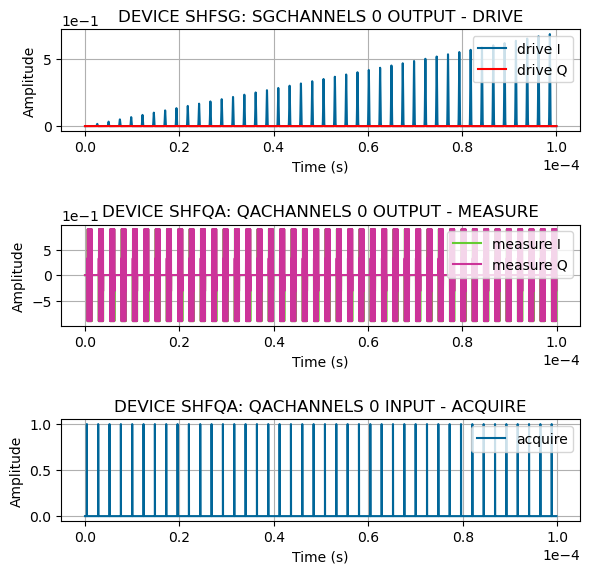

[2023.11.13 14:21:27.853] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2023.11.13 14:21:27.863] INFO    Starting LabOne Q Compiler run...
[2023.11.13 14:21:27.879] INFO    Schedule completed
[2023.11.13 14:21:28.001] INFO    Finished LabOne Q Compiler run.
[2023.11.13 14:21:28.121] INFO    Writing html file to u:\LabOneQ Software Local Samuel\laboneq\LabPC_Software\Pulse_Sheets\Amplitude_Rabi_2023-11-13-14-21-27.html
[2023.11.13 14:21:28.170] INFO    Configuring the device setup
[2023.11.13 14:21:28.176] INFO    The device setup is configured
[2023.11.13 14:21:28.236] INFO    Starting near-time execution...
[2023.11.13 14:21:28.332] INFO    Finished near-time execution.
[2023.11.13 14:21:28.350] WARNING instance of class NumpyArrayRepr may not serialize properly
[2023.11.13 14:21:28.353] WARNING instance 

In [38]:
# Simulate experiment
plot_simulation(compiled_rabi, 0, 100e-6)
show_pulse_sheet("Pulse_Sheets/Amplitude_Rabi", compiled_rabi)

#Run, Save and Plot Results
# run the compiled experiemnt
rabi_results = session.run(compiled_rabi)

timestamp = time.strftime("%Y%m%dT%H%M%S")
#Create Results Folder
Path("Results").mkdir(parents=True, exist_ok=True)
#Save the results with a time stamp
session.save_results(f"Results/{timestamp}_rabi_results.json")
print(f"File saved as Results/{timestamp}_rabi_results.json")

# get measurement data returned by the instruments
rabi_res = rabi_results.get_data("amp_rabi")

# define amplitude axis from qubit parameters
rabi_amp = rabi_results.get_axis("amp_rabi")[0]

## Plot

Fitted parameters: [ 9.41324548e+00 -3.70731253e-10 -1.08984513e-11  4.10156250e-02]
0.16687085557452794
0.3337417111490559


c:\Users\sam68451\.conda\envs\laboneq_env\Lib\site-packages\numpy\lib\function_base.py:626: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
c:\Users\sam68451\.conda\envs\laboneq_env\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


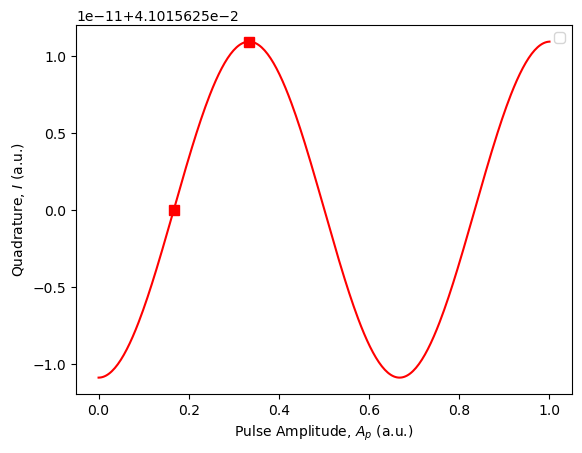

In [39]:
# plot measurement data
fig = plt.figure()

# angle used to rotate data in IQ plane to maximize signal in I component 
data_rot = -2*np.pi/3


# increase number of plot points for smooth plotting of fit results
amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))

# fit measurement results - assume sinusoidal oscillation with drive amplitude
popt, pcov = oscillatory.fit(rabi_amp, rabi_res, 10, 0, 1, 1.2, plot=False)
print(f"Fitted parameters: {popt}")

# plot fit results together with measurement data
plt.plot(amp_plot, oscillatory(amp_plot, *popt), "-r");

pi_half_amp = np.pi/2/popt[0]
pi_amp = np.pi/popt[0]
plt.plot([pi_half_amp, pi_amp],func_osc(np.array([pi_half_amp, pi_amp]),*popt), 'sr', markersize=7)

# plot measurement data
#plt.plot(rabi_amp, np.real(rabi_res*np.exp(1j*data_rot)), '.b', label='data')
plt.ylabel('Quadrature, $I$ (a.u.)')
plt.xlabel('Pulse Amplitude, $A_p$ (a.u.)')
plt.legend();


# update qubit parameters - pulse amplitudes for pi and pi/2 pulses

qubit_parameters['pi_half_amp'] = pi_half_amp
print(qubit_parameters['pi_half_amp'])

qubit_parameters['pi_amp'] = pi_amp
print(qubit_parameters['pi_amp'])

# 3. Pulse Rabi Oscillation

It is expected, that you first run 0.1-0.5

In [22]:
## define pulses

# qubit drive pulse - unit amplitude, but will be scaled with sweep parameter
x90 = pulse_library.gaussian(uid="x90", length=100e-9, amplitude=1.0)
# readout drive pulse
readout_pulse = pulse_library.const(uid="readout_pulse", length=400e-9, amplitude=1.0)
# readout integration weights
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=400e-9, amplitude=1.0
)

In [23]:
# set up sweep parameter - drive pulse length
start = 30e-9
stop = 200e-9
count = 11
length_sweep = LinearSweepParameter(uid="length", start=start, stop=stop, count=count)

# number of averages
average_exponent = 1  # used for 2^n averages, n=average_exponent, maximum: n = 17

# Create Experiment
exp = Experiment(
    uid="Length Rabi",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)
## experimental pulse sequence
# outer loop - real-time, cyclic averaging in standard integration mode
with exp.acquire_loop_rt(
    uid="shots",
    count=pow(2, average_exponent),
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
    repetition_mode=RepetitionMode.AUTO,  # the compiler determines the optimal shot repetition rate
):
    # inner loop - real-time sweep of qubit drive pulse amplitude
    with exp.sweep(
        uid="sweep", parameter=length_sweep, alignment=SectionAlignment.RIGHT
    ):
        # qubit excitation - pulse length will be swept
        with exp.section(uid="qubit_excitation", alignment=SectionAlignment.RIGHT):
            exp.play(signal="drive", pulse=x90, length=length_sweep)
        # qubit readout pulse and data acquisition
        with exp.section(uid="qubit_readout", play_after="qubit_excitation"):
            # play readout pulse
            exp.play(signal="measure", pulse=readout_pulse)
            # signal data acquisition
            exp.acquire(
                signal="acquire",
                handle="ac_0",
                kernel=readout_weighting_function,
            )
        # relax time after readout - for signal processing and qubit relaxation to ground state
        with exp.section(uid="relax", play_after="qubit_readout"):
            exp.delay(signal="measure", time=1e-6)

In [25]:
# set signal map to qubit 0
exp.set_signal_map(signal_map_default("q0"))

# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

# run experiment on qubit 0
my_results = session.run(exp)

[2023.11.13 14:08:19.930] INFO    Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is u:\LabOneQ Software Local Samuel\laboneq\LabPC_Software\laboneq_output\log
[2023.11.13 14:08:19.937] INFO    VERSION: laboneq 2.18.0
[2023.11.13 14:08:19.942] INFO    Connecting to data server at 192.168.1.10:8004
[2023.11.13 14:08:19.947] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at 192.168.1.10:8004
[2023.11.13 14:08:19.981] INFO    Configuring the device setup
[2023.11.13 14:08:20.014] INFO    The device setup is configured
[2023.11.13 14:08:20.025] INFO    Starting LabOne Q Compiler run...
[2023.11.13 14:08:20.036] INFO    Schedule completed
[2023.11.13 14:08:20.119] INFO     ────────────────────────────────────────────────────────────────── 
[2023.11.13 14:08:20.136] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2023.11.13 14:08:20.140] INFO     ─────────────────────────────────────────────

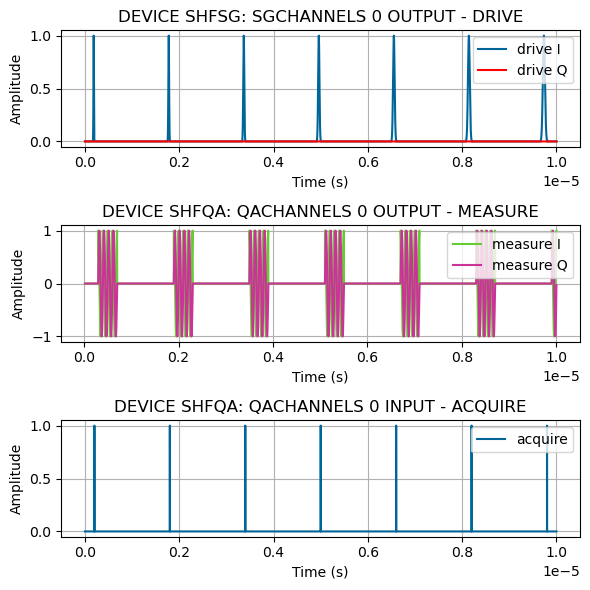

In [26]:
# Plot simulated output signals
plot_simulation(session.compiled_experiment, 0, 10e-6)

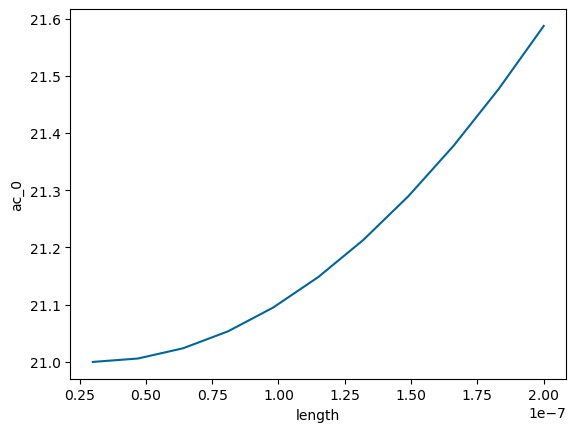

In [30]:
# plot measurement results
plot_result_2d(my_results, "ac_0")

In [27]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("Length Rabi", session.compiled_experiment)

[2023.11.13 14:08:38.051] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2023.11.13 14:08:38.070] INFO    Starting LabOne Q Compiler run...
[2023.11.13 14:08:38.084] INFO    Schedule completed
[2023.11.13 14:08:38.117] INFO    Finished LabOne Q Compiler run.
[2023.11.13 14:08:38.481] INFO    Writing html file to u:\LabOneQ Software Local Samuel\laboneq\LabPC_Software\Length Rabi_2023-11-13-14-08-38.html


u:\LabOneQ Software Local Samuel\laboneq\LabPC_Software\Length Rabi_2023-11-13-14-08-38.html

# Resonator Spectroscopy

In [ ]:
# frequency range of spectroscopy scan - around expected centre frequency as defined in qubit parameters
spec_range = 50e6
# how many frequency points to measure
spec_num = 201

# define sweep parameters for two qubits
freq_sweep_q0 = LinearSweepParameter(uid="res_freq", start=qubit_parameters['ro_freq'] - spec_range / 2, stop=qubit_parameters['ro_freq'] + spec_range / 2, count=spec_num)

# take how many averages per point: 2^n_average
n_average = 14

# spectroscopy excitation pulse
readout_pulse_spec = pulse_library.const(
    length=qubit_parameters['ro_len_spec'], amplitude=qubit_parameters['ro_amp_spec']
)
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter
def res_spectroscopy(freq_sweep):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"), 
            ExperimentSignal("acquire"),
        ]
    )         
                
    with exp_spec.acquire_loop_rt(
            uid="shots",
            count=pow(2, n_average),
            acquisition_type=AcquisitionType.SPECTROSCOPY,
            averaging_mode=AveragingMode.SEQUENTIAL
    ):
        with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
            # readout pulse and data acquisition
            with exp_spec.section(uid="spectroscopy"):
                
                # play resonator excitation pulse
                exp_spec.play(
                    signal="measure", 
                    pulse=readout_pulse_spec
                )
                
                # resonator signal readout 
                exp_spec.acquire(
                    signal="acquire", 
                    handle="res_spec", 
                    length=qubit_parameters['ro_len_spec']
                )
                
            with exp_spec.section(uid="delay"):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec.delay(signal="measure", time=1e-6)
    
    return exp_spec
# function that returns the calibration of the readout line oscillator for the experimental signals
def res_spec_calib(freq_sweep):
        exp_calibration = Calibration()
        # sets the oscillator of the experimental measure signal
        exp_calibration["measure"] = SignalCalibration(
                # for spectroscopy, use the hardware oscillator of the QA, and set the sweep parameter as frequency
                oscillator = Oscillator(
                        "readout_osc",
                        frequency=freq_sweep,
                        modulation_type=ModulationType.HARDWARE
                    ),
                )
                
        return exp_calibration

# signal map - maps the logical signal of the device setup to the experimental signals of the experiment
res_spec_map_q0 = {
    "measure": "/logical_signal_groups/q0/measure_line",
    "acquire": "/logical_signal_groups/q0/acquire_line",
    }

In [ ]:
# define the experiment with the frequency sweep relevant for qubit 0
exp_spec = res_spectroscopy(freq_sweep_q0)

# set signal calibration and signal map for experiment to qubit 0
exp_spec.set_calibration(res_spec_calib(freq_sweep_q0))
exp_spec.set_signal_map(res_spec_map_q0)

# compile the experiment 
compiled_experiment = session.compile(exp_spec)

# run the experiment
my_results = session.run(compiled_experiment)

# get the measurement data returned by the instruments from the QCCS session
spec_res = my_results.get_data('res_spec')

# define the frequency axis from the qubit parameters
spec_freq = lo_settings['ro_lo'] + my_results.get_axis('res_spec')[0]

# plot the measurement data 
fig, ax = plt.subplots(1, 1)
ax.plot(spec_freq / 1e9, abs(spec_res), '.b', label='data')
ax.set_ylabel('Amplitude, $A$ (a.u.)')
ax.set_xlabel('Frequency, $\\nu$ (GHz)')

# increase number of plot points for smooth plotting of fit results
freq_plot = np.linspace(spec_freq[0], spec_freq[-1], 5 * len(spec_freq))

# fit the measurement data to a Fano lineshape to extract the resonance frequency
popt, pcov = fit_ResSpec(spec_freq, abs(spec_res), 10e6, 7.0e9, 0.5e-6, fano=1, off=1.0e-6, plot=False)

# plot the fit function together with the measurement data
ax.plot(freq_plot / 1e9, func_Fano(freq_plot, *popt), '-r', label='fit')
ax.legend();
# choose the readout frequency at the minimum of the fitted lineshape
qubit_parameters['ro_freq'] = freq_plot[np.argmin(func_Fano(freq_plot, *popt))] - lo_settings['ro_lo']
print(str((qubit_parameters['ro_freq']+lo_settings['ro_lo'])/1e9) + " GHz")

# Pulsed Qubit Spectroscopy

In [ ]:
# frequency range of spectroscopy scan - defined around expected qubit frequency as defined in qubit parameters
qspec_range = 0.5e6
# how many frequency points to measure
qspec_num = 51

# set up sweep parameters - qubit drive frequency
freq_sweep_q0 = LinearSweepParameter(uid="freqqubit", start=qubit_parameters['qb_freq'] - qspec_range/2, stop=qubit_parameters['qb_freq'] + qspec_range/2, count=qspec_num)

# how many averages per point: 2^n_average
n_average = 14

# square pulse to excite the qubit 
square_pulse = pulse_library.const(
    uid="const_iq", length=qubit_parameters['qb_len_spec'], amplitude=qubit_parameters['qb_amp_spec']
)
# qubit readout pulse - here simple constant pulse
readout_pulse = pulse_library.const(
    uid="readout_pulse", length=qubit_parameters['ro_len'], amplitude=qubit_parameters['ro_amp']
)
# integration weights for qubit measurement - here simple constant weights, i.e. all parts of the return signal are weighted equally
readout_weighting_function = pulse_library.const(
    uid="readout_weighting_function", length=qubit_parameters['ro_len'], amplitude=1.0
)
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter
def qubit_spectroscopy(freq_sweep):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ]
    )
            
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(uid="freq_shots", count=pow(2, n_average),
                                   acquisition_type=AcquisitionType.INTEGRATION,
                                   averaging_mode=AveragingMode.SEQUENTIAL):
            
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                exp_qspec.play(signal="drive", pulse=square_pulse)
            with exp_qspec.section(uid="readout_section", play_after="qubit_excitation"):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_weighting_function,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=1e-6)
            
    return exp_qspec
# experiment signal calibration for qubit 0
exp_calibration_q0 = Calibration()
exp_calibration_q0["drive"] = SignalCalibration(
        oscillator = Oscillator(
                frequency=freq_sweep_q0,
                modulation_type=ModulationType.HARDWARE,
                ),
            )

exp_calibration_q0["measure"] = SignalCalibration(
        oscillator = Oscillator(
                frequency=qubit_parameters['ro_freq'],
                modulation_type=ModulationType.SOFTWARE,
                ),
            )
exp_calibration_q0["acquire"] = SignalCalibration(
        oscillator = Oscillator(
                frequency=qubit_parameters['ro_freq'],
                modulation_type=ModulationType.SOFTWARE,
                ),
            )

# signal map for qubit 0
q0_map = {"drive": "/logical_signal_groups/q0/drive_line",
        "measure": "/logical_signal_groups/q0/measure_line",
        "acquire": "/logical_signal_groups/q0/acquire_line",
        }

In [ ]:
# define experiment with frequency sweep
exp_qspec = qubit_spectroscopy(freq_sweep_q0)

# apply calibration and signal map
exp_qspec.set_calibration(exp_calibration_q0)
exp_qspec.set_signal_map(q0_map)

# compile the experiment 
compiled_experiment = session.compile(exp_qspec)

# run the experiment
my_results = session.run(compiled_experiment)
# get measurement data returned by the instruments
qspec_res = my_results.get_data('qb_spec')

# define a frequency axis from the parameters
qspec_freq = lo_settings['qb_lo'] + my_results.get_axis('qb_spec')[0]
fig = plt.figure()

# increase number of plot points for smooth plotting of fit reults
freq_plot = np.linspace(qspec_freq[0], qspec_freq[-1], 5 * len(qspec_freq))

# fit measurement data to a Lorentzian lineshape
popt, pcov = fit_Spec(qspec_freq, abs(qspec_res), 0.1e6, 4.0e9, 0.001, off=1e-4, plot=False)

# plot fit results together with measurement data
plt.plot(freq_plot / 1e9, func_lorentz(freq_plot, *popt), '-r', label='fit')

# plot measurement data
plt.plot(qspec_freq / 1e9, abs(qspec_res), 'b.', label='data')
plt.ylabel('Amplitude, $A$ (a.u.)')
plt.xlabel('Frequency, $\\nu$ (GHz)')
plt.legend();
# update qubit parameters
qubit_parameters['qb_freq'] = popt[1] - lo_settings['qb_lo']
print(str((qubit_parameters['qb_freq'] + lo_settings['qb_lo'])/1e9) + " GHz")

# Single Shot Readout